# Basic NER

In [1]:
%matplotlib inline
%pylab inline

import nltk
import pandas as pd
import codecs
import preprocess

# this bits here are just for pretty plots
pylab.rcParams['figure.figsize'] = (20, 13)
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:

articles_trump = [
    """
    Ben Jacobs in Washington DC
    @Bencjacobs

    Tuesday 23 August 2016 01.13 BST
    Last modified on Tuesday 23 August 2016 10.32 BST

        Share on LinkedIn
        Share on Google+

    Donald Trump veered off the teleprompter on Monday night to claim that “inner cities run by the Democrats” were more dangerous than countries such as Iraq and Afghanistan.

    The Republican nominee was meant to be delivering a scripted speech calling for Hillary Clinton be investigated by a special prosecutor. However, once again he veered off message in an attempt to appeal to minority voters in apocalyptic terms.

    “You can go to war zones in countries that we are fighting and it is safer than living in some of our inner cities that are run by the Democrats,” Trump said. The Republican nominee also promised if elected, “we’ll get rid of the crime. You’ll be able to walk down the street without getting shot. Now, you walk down the street, you get shot.”

    Trump has made increased appeals for support from African Americans in recent days. Despite that, a recent NBC/Wall Street Journal poll showed Trump receiving the support of only 1% of African American voters, a historically low total. The poll did have a margin of error of plus or minus 3.5%. The Republican nominee has repeatedly argued that African American voters should support him in the past week, saying: “What have you got to lose?” In contrast, the New York real estate developer has railed against what he called “the bigotry of Hillary Clinton, who sees people of color only as votes and not as human beings worthy of a better future”.

    The intended focus of the Republican nominee’s message on Monday was his call for a special prosecutor to investigate Clinton’s leadership of the state department. Trump claimed that the FBI and Department of Justice could not be trusted to investigate “Hillary Clinton’s crimes”. The FBI in July decided not to pursue criminal charges against Clinton for her use of an unsecured private email server while secretary of state. However, in doing so, FBI Director James Comey rebuked Clinton for the “extremely careless” way in which she handled her emails.

    In the speech, Trump also said he was “fighting for peaceful regime change in our country” and warned gravely of potential election fraud. “You got to go out and watch. You know what I’m talking about.” Trump has long made unsubstantiated claims about “a rigged election” and warned of in-person voter fraud recently at a campaign stop in Pennsylvania. However, an exhaustive investigation of in-person voter fraud in the United States found only 31 cases since 2000 out of more than 1bn ballots cast.

    Trump spoke in the blue collar city of Akron, Ohio. The Buckeye State has 18 electoral votes, and no Republican has ever won the White House without winning Ohio. According to data complied by Real Clear Politics, Clinton has not trailed in a single statewide poll of Ohio since April. However, despite these sagging poll numbers and cryptic warnings about election fraud, Trump was still confident of victory: “I just get the feeling that we’re going to win in a landslide.”

    """
]

In [3]:
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from itertools import chain

In [4]:
# nltk comes with utils to chunk text into sentences
text = "I love Chocolate. \n Mango smoothie is yummy."
nltk.sent_tokenize(text)

['I love Chocolate.', 'Mango smoothie is yummy.']

In [5]:
# nltk comes with utils to tokenize a sentence
nltk.word_tokenize("I love Chocolate.")

['I', 'love', 'Chocolate', '.']

In [6]:
nltk.pos_tag(['I', 'love', 'Chocolate', '.'])

[('I', 'PRP'), ('love', 'VBP'), ('Chocolate', 'NNP'), ('.', '.')]

In [7]:

"""
NLTK comes with default trained packages ready for
doing NER I'm just putting the blocks together here

1. Text -> to Sentences : [s1, s2, s3]
2. Sentence to Words (Tokenization) : [w1, w2, w3...]
3. Pos tagging each sentence: [w1: postag1, w2: postag2]  ...
4. Passing the pos tagger to the chunker (NER)
"""
    
def entities(text):
    
    """
    Extracts entities out of a sentence
    """
    def get_entities_from_sent(sentence):
        # Tokenizes a sentence: Word1, Word2 ... Word2n
        words = nltk.word_tokenize(sentence)
        # Pos tags the words of a sentence
        postagged_sentence = nltk.pos_tag(words)
        # returns a tree with the rules established in the Name entity Chunker
        return nltk.ne_chunk(postagged_sentence, binary=True)

    """
    chunks a text into sentences
    and returns the entities found in each sentence
    """
    def get_basic_entities(text):
        entities = [get_entities_from_sent(sentence) for sentence in nltk.sent_tokenize(text)]
        return entities
    
    # preprocess.get_continuous_chunks
    # is a function to flatten the returned tree
    found_entities = chain(*[preprocess.get_continuous_chunks(chunk) for chunk in get_basic_entities(text)])
    return list(found_entities)


In [8]:
entities("David works for the Bank Of America. \n Vietnam is a country in South East Asia. ")

['David', 'Bank Of America', 'Vietnam', 'South East Asia']

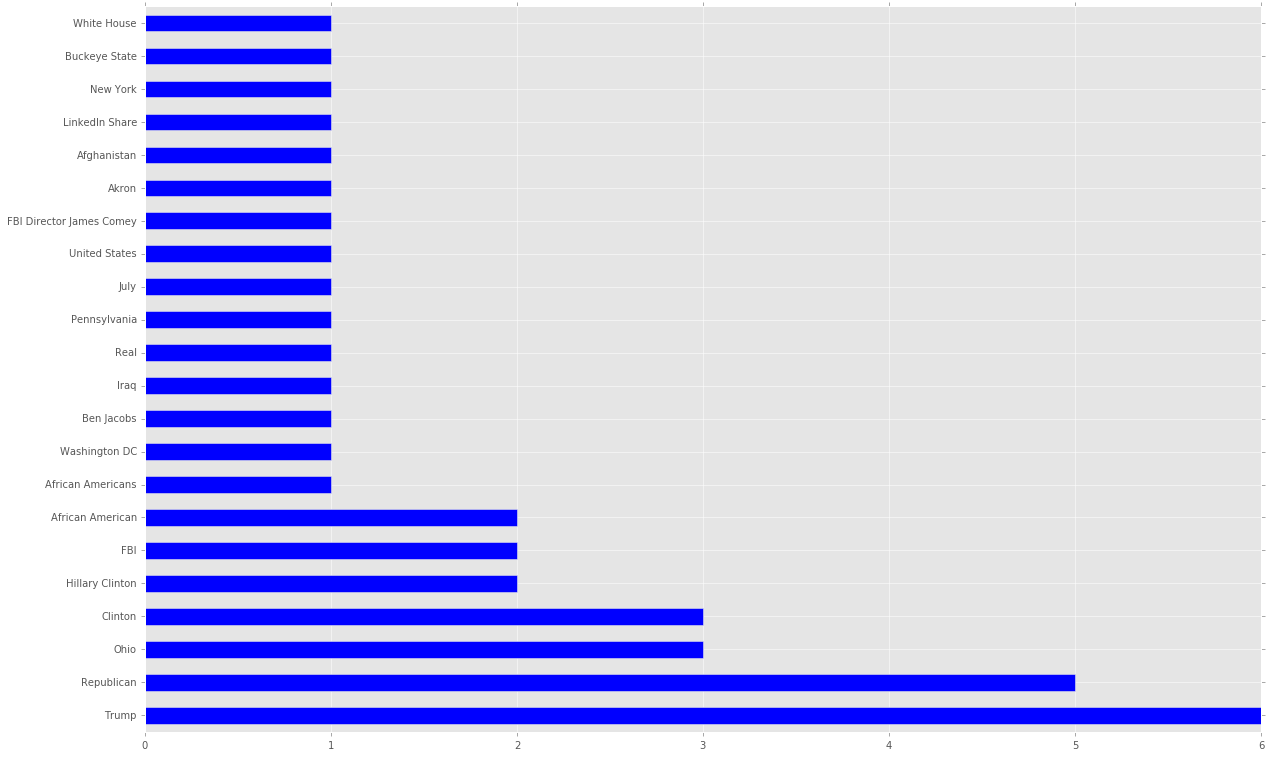

In [9]:
entities_article= entities("\n".join(articles_trump))
# plotting the topic distributions in trump's news article
topics = pd.DataFrame(entities_article, columns=['topic'])
topics.topic.value_counts().plot(kind='barh')

In [10]:
topics.topic.value_counts()

Trump                       6
Republican                  5
Ohio                        3
Clinton                     3
Hillary Clinton             2
FBI                         2
African American            2
African Americans           1
Washington DC               1
Ben Jacobs                  1
Iraq                        1
Real                        1
Pennsylvania                1
July                        1
United States               1
FBI Director James Comey    1
Akron                       1
Afghanistan                 1
LinkedIn Share              1
New York                    1
Buckeye State               1
White House                 1
Name: topic, dtype: int64

# Problems

- lots of processing (i.e: POS)
- hard to deal with noisy cases i.e: `United states of AMerica`
- can't link extracted `entities` to more information

In [11]:
entities("United States of America is a country.") 

['United States', 'America']

In [12]:
entities("The United States Of America is a country.") 

['United States Of America']

In [13]:
entities("U.S.A is a country in America.") 

['U.S.A', 'America']

In [14]:
entities("united states is a country in America.")

['America']

---


----
# Entity Linking

## I'm cheating a bit..
### Im only calling `Dbpedia Spotlight's` API

Lets check the demo api: https://dbpedia-spotlight.github.io/demo/

In [15]:
import requests
import json

In [16]:
"""
Just making a rest request to spotlight's demo API
"""
def spotlight(text):
    try:
        url = 'http://spotlight.sztaki.hu:2222/rest/annotate'
        headers = {'accept': 'application/json'}
        data = {
            'text': text,
            'confidence': 0.3,
            'support':10
        }
        return requests.post(url, data=data, headers=headers).json()
    except Excepion as e:
        print("error : %s"%e)

def entities_via_spotlight(text):
    response = spotlight(text)
    return [entity['@URI'].split("/resource/")[-1] for entity in response['Resources']]


In [17]:
spotlight_entities = entities_via_spotlight(articles_trump[0])
topics_spotlight = pd.DataFrame(spotlight_entities, columns=['topic'])

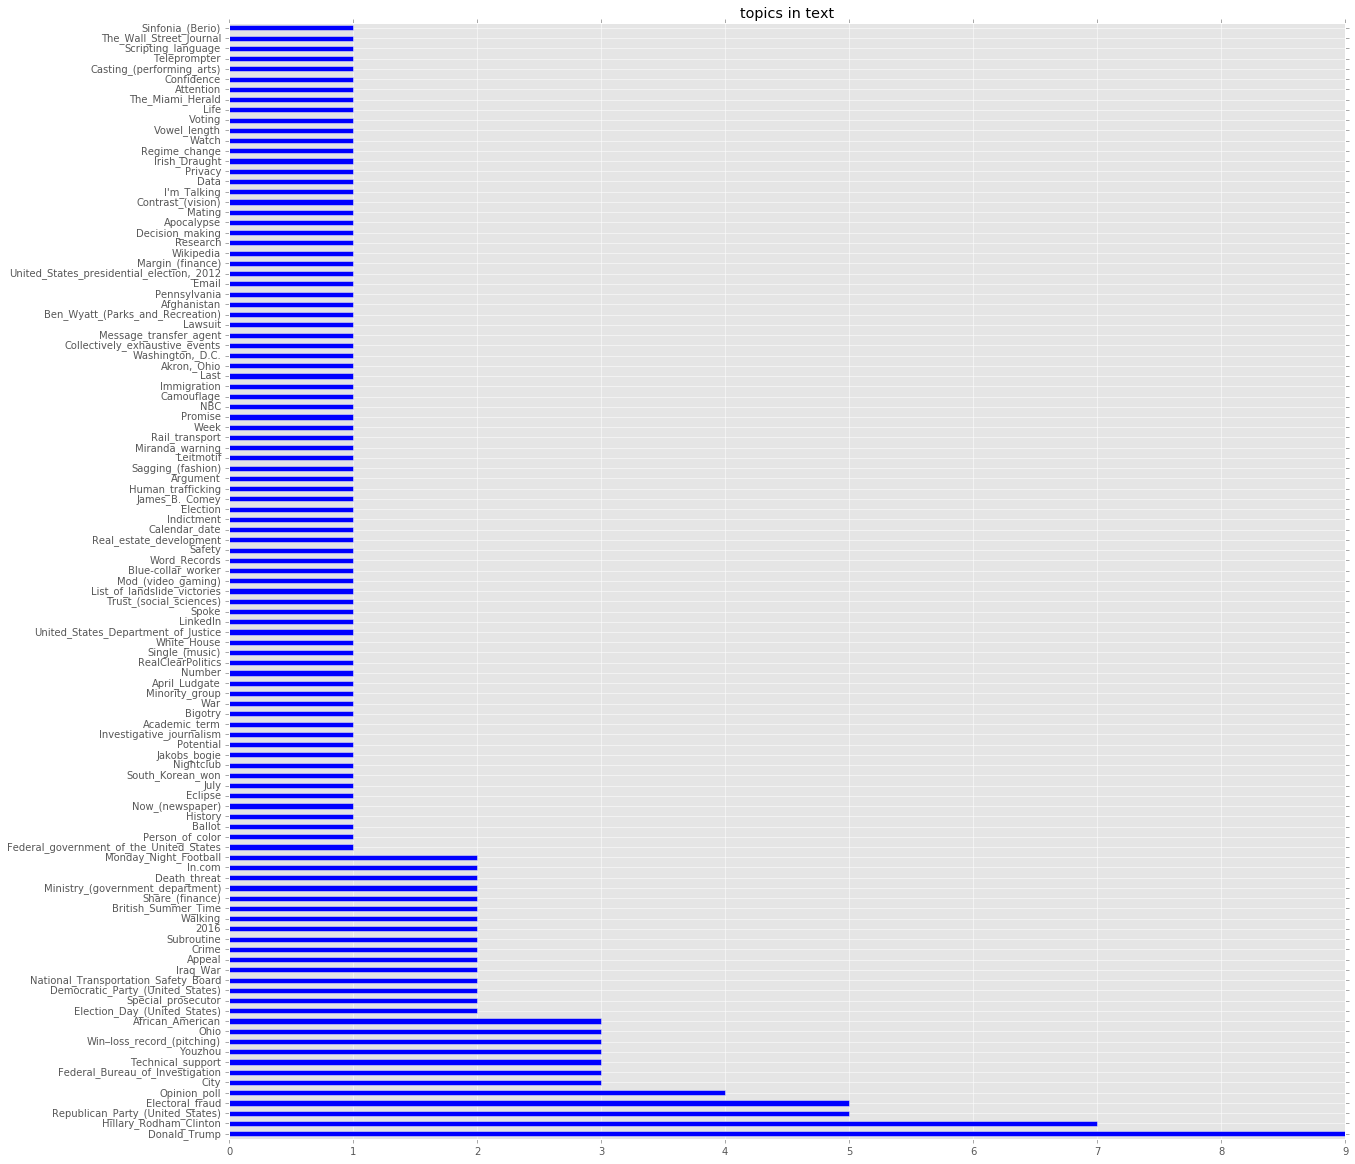

In [18]:
pylab.rcParams['figure.figsize'] = (20, 20)
topics_spotlight.topic.value_counts().plot(kind='barh', title='topics in text')

 anchor: `Clinton` -> Topic: `Hillary_Rodham_Clinton`

----

## Hard work is on processing the wikipedia in this case
----

## Using Knowledge base information

### We can check Donald's trump info on wikidata:

https://www.wikidata.org/wiki/Q22686


### DBpedia
http://dbpedia.org/page/Donald_Trump

## Lots of info on wikidata just as a sample:

https://query.wikidata.org/#%23Presidents%20and%20their%20causes%20of%20death%20ranking%0A%0A%23defaultView%3ABubbleChart%0ASELECT%20%3Fcid%20%3Fcause%20%28count%28%2a%29%20as%20%3Fcount%29%0AWHERE%20%7B%0A%09%3Fpid%20wdt%3AP39%20wd%3AQ11696%20.%0A%09%3Fpid%20wdt%3AP509%20%3Fcid%20.%0A%09OPTIONAL%20%7B%0A%09%09%3Fcid%20rdfs%3Alabel%20%3Fcause%20filter%20%28lang%28%3Fcause%29%20%3D%20%22en%22%29%20.%0A%09%7D%0A%7D%0AGROUP%20BY%20%3Fcid%20%3Fcause%0AORDER%20BY%20DESC%28%3Fcount%29%20ASC%28%3Fcause%29

 Playing with APIs you could simple do something like:
 - get me all topics which are politicians
 - and get me their political party

### Using Entity Embeddings



On top of the structured data presented above you got access to word embeddings for entities check:
https://github.com/idio/wiki2vec    

# 😰 hopefully I have enough ram for this

In [ ]:
## insert word embeddings part here

----
# LDA



In [19]:
from gensim.models import ldamodel
from gensim.corpora import Dictionary
import numpy as np
from gensim.models.coherencemodel import CoherenceModel

ImportError: No module named 'gensim.models.coherencemodel'

In [ ]:
articles = list([line for line in codecs.open('corpus2.lines','r','utf-8')])

In [ ]:
len(articles)

In [ ]:
# preprocess contain a function which takes a text:
# tokenize it: Word1, Word2 ...
# removes stopwords
# and stems it: 
# Playing -> Play
# Played -> Play
tokenized_articles = list([preprocess.tokenize_and_stem_text(article) for article in articles])
tokenized_articles[:1]

In [ ]:
# Creating a frequency table, how many times a word appears in each article
dictionary = Dictionary(tokenized_articles)
dictionary.filter_extremes(no_below=2, no_above=0.7, keep_n=10000)
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in tokenized_articles]

In [ ]:
# how many time word X appears in each document
# gensim uses numbers as placeholders for words
# doucment 1
# word1: 10
# word2: 20
# word3: 1


# document 2:
# word1: 1
# word2: 10
corpus[:1]

In [ ]:
np.random.seed(1) # setting random seed to get the same results each time.
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, passes=12, iterations=800)
goodcm = CoherenceModel(model=model, texts=tokenized_articles, dictionary=dictionary, coherence='c_v')
goodcm.get_coherence()

In [ ]:
model.print_topics(10)

-----

- corpus http://mlg.ucd.ie/datasets/bbc.html


In [ ]:

import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [ ]:
vis_data = gensimvis.prepare(model, corpus, dictionary)
pyLDAvis.display(vis_data)

# numbers in the visualization (or area of the circle is prevalcne)
# bigger numbers mean more prevalence
# prevalence = number of tokens of topic/ total number of tokens all corpus
# Jensen–Shannon divergence showing semantic distance accross topics
# Lambda parameter lets you drag the most distinct terms of a topic

In [ ]:
sample = """

Steve McQueen, the visual artist and maker of three award-winning feature films, is to receive the British Film Institute’s highest accolade.

McQueen will become the youngest director to receive the BFI fellowship when it is presented to him at the awards ceremony of the London film festival on 15 October, six days after his 47th birthday.

McQueen, who won the Turner prize in 1999, has quickly established himself as one of the UK’s most respected film-makers responsible for Hunger (2008), Shame (2011) and the Oscar-winning 12 Years a Slave (2013).

"""
model[dictionary.doc2bow(preprocess.tokenize_and_stem_text(sample))]


In [ ]:
sample = """

Steam is a digital distribution platform developed by Valve Corporation offering digital rights management (DRM), multiplayer gaming and social networking services. Steam provides the user with installation and automatic updating of games on multiple computers, and community features such as friends lists and groups, cloud saving, and in-game voice and chat functionality. The software provides a freely available application programming interface (API) called Steamworks, which developers can use to integrate many of Steam's functions into their products, including networking, matchmaking, in-game achievements, micro-transactions, and support for user-created content through Steam Workshop.

"""
model[dictionary.doc2bow(preprocess.tokenize_and_stem_text(sample))]

# Evaluating
## Reading Tea Leaves: How Humans Interpret Topic Models
https://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models

It measures how often the topic words appear together in the corpus
correlate well with human judgement.

### Higher coherence = better models

In [ ]:
goodcm = CoherenceModel(model=model, texts=tokenized_articles, dictionary=dictionary, coherence='c_v')
goodcm.get_coherence()